<a href="https://colab.research.google.com/github/sophuang/0042Project_TrafficPrediction/blob/main/good_version_of_0042_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Data without missing values

In [ ]:
import pandas as pd

volume_df = pd.read_csv('/content/traffic_volume_df_no.csv')
volume_df = pd.DataFrame(volume_df)
volume_df.index.max()

108

In [ ]:
import keras
import tensorflow

In [ ]:
test = volume_df.iloc[:, 6:678]
test1=test.apply(pd.to_numeric)
test1.shape

(109, 672)

These functions constructing the ST-LSTM is referenced from https://github.com/IBM/spatial-lstm/blob/master/Model/model.py


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers import  Masking
from scipy.interpolate import UnivariateSpline,CubicSpline
output = '/content/'
#---------------------------data analysis-------------------------------------
# flattern the batch time series data into a m by n matrix
# m= p.shape[1]: number of sensors, n=p.shape[0]*p.shape[2]: time steps
def flattern(p):
    pred_y_matrix = [[]for _ in range(len(p[0])) ]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix


# interpolate the missing values with mask value
def interpolate(data, mask):
    temp = [list(dd) for dd in data]
    d = []
    for i in range(len(temp)):
        for j in range(len(temp[i])):
            if temp[i][j] == mask: temp[i][j]= float("NaN")
        df = pd.Series(temp[i]).interpolate(method='linear')
        d.append(df.tolist())
    return d

#Continous data split for masked and unmasked data:
def split_train(Int_dat, Norm_dat,T1,T2,T3,Stride, start, end,data_name):
    length  = len(Int_dat[0])
    s = int(length*start)
    e = int(length*end)
    Train = [ N[:s] + N[e:] for N in Norm_dat ]
    Test  = [ M[s:e] for M in Int_dat ]
    print('Training Data Length: ', len(Train),'X',len(Train[0]))
    print('Test Data Length: ', len(Test), 'X',len(Test[0]))
    print('Testing percentage: ',len(Test[0])/(len(Test[0])+len(Train[0]))*100,'%' )
    print('Total data size: ', len(Int_dat), 'X', len(Int_dat[0]))
    np.savetxt(data_name + '_train.txt', np.exp(np.array(Train)))
    np.savetxt(data_name + '_test.txt', np.exp(np.array(Test)))
    train_x, train_y = data_split(Train, T1, T2, T3,Stride)
    test_x, test_y = data_split(Test, T1, T2, T3,Stride)
    return train_x, train_y, test_x, test_y
    
# split data for Multivairate time series (matrix of sensors)
# the data is feed to Bidirectional LSTM model
def data_split(dat, train_hour, test_hour, predict_position, stride):
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    
    print("period:", period)
    print("len(dat[0]):", len(dat[0]))

    while i + period <= len(dat[0]):
        x_temp = []
        y_temp = []
        for j in range(len(dat)):
            x_temp.append(dat[j][i:i + train_hour])
            y_temp.append(dat[j][i+ train_hour+ predict_position:i+ train_hour+ predict_position +test_hour])
        
        x.append(np.array(x_temp))
        y.append(np.array(y_temp))
        i += stride
        print("i:", i)

    
    print("Final x shape:", np.array(x).shape)
    print("Final y shape:", np.array(y).shape)
    
    return np.array(x), np.array(y)



# Data normalization:
# using log function and skip the masked data with -1
# 0 values are replaced by 1e-5 in order to avoid nan value in log
def data_normalize(Dat):
    new_dat  = []
    for d in Dat:
        unique_d = sorted(list(set(d)))
        if len(unique_d) > 1:
            min, max = np.min(unique_d[1]), np.max(d)
        else:
            min, max = unique_d[0], unique_d[0]
        a = max - min
        temp = []
        for val in d:
            if val == -1:
                temp.append(val)
            else:
                norm = np.log(val) if val != 0 else 1e-5
                temp.append(norm)
        new_dat.append(temp)

    return new_dat


#---------------------------MAE STD-------------------------------------
def log_mae(py,ty, t,plot_name):
    print('predict data size: ',len(py),len(py[0]))
    print('exact data size: ', len(ty), len(ty[0]))
    mae_lis = []
    std = []
    for i in range(len(py)):
        mae = np.exp(np.array(py[i])) - np.exp(np.array(ty[i]))
        print('Predicted Data Point size for sensor '+str(i+1)+' ', len(mae))
        mae = np.abs(mae)
        mae_lis.append(np.mean(np.abs(mae)))
        std.append(np.std(mae))
    return mae_lis, std

#---------------------------Plot-------------------------------------
def py_ty_plot(data_py, data_ty, s, p,data_name, idx):
    l = len(data_py[0])
    x = range(len(data_py[0]))
    y = data_py[idx]
    xs = np.linspace(0, l, p)
    ss = UnivariateSpline(x, y)
    ys = ss(xs)
    plt.figure()
    plt.title('Sensor No: ' + str(idx + 1))
    plt.scatter(range(l),y ,s = s)
    plt.plot(xs, ys,label = 'Sp')
    y = data_ty[idx]
    ss = UnivariateSpline(x, y)
    ys = ss(xs)
    plt.plot(xs, ys,label = 'Exact')
    plt.scatter(range(l),data_ty[idx],s = s)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=3, fancybox=True, shadow=True)
    plt.savefig(output + data_name+'_Time_series_sensor_No'+str(idx)+'.pdf',bbox_inches='tight')
    plt.show()
    return

# Heatmap of two matrix
def multi_heatmap(Test_y, Pred_y, t,plot_name):
    Test_y = Test_y.reshape(Test_y.shape[0],Test_y.shape[1],Test_y.shape[2])
    Pred_y = Pred_y.reshape(Pred_y.shape[0],Pred_y.shape[1],Pred_y.shape[2])
    py = flattern(Pred_y)
    ty = flattern(Test_y)
    min, max = np.min(ty), np.max(ty)
    #Plot the new heatmap of predict data vs test data
    plt.figure()
    print(len(py),len(ty))
    ax1 = sns.heatmap(np.array(ty),vmin = min, vmax = max)
    ax1.set_title('Exact Data')
    ax1.set(xlabel='Time Step', ylabel='Sensors')
    f1 = ax1.get_figure()
    f1.savefig(output + str(plot_name) + '_Exact_heatmap.pdf',bbox_inches='tight')
    plt.show()
    plt.figure()
    ax2 = sns.heatmap(np.array(py),vmin = min, vmax = max)
    ax2.set_title('Predicted Data')
    ax2.set(xlabel='Time Step', ylabel='Sensors')
    f2 = ax2.get_figure()
    f2.savefig(output + str(plot_name) + '_Predicted_heatmap.pdf',bbox_inches='tight')
    plt.show()
    plt.figure()
    error = np.array(py) - np.array(ty)
    print('error shape: ', error.shape)
    ax3 = sns.heatmap(error,vmin = min, vmax = max)
    ax3.set_title('Error Map')
    ax3.set(xlabel='Time Step', ylabel='Sensors')
    f3 = ax3.get_figure()
    f3.savefig(output + str(plot_name) + '_Error_heatmap.pdf',bbox_inches='tight')
    plt.show()
    #return the mae and std after plot
    MAE_lis, STD_lis = log_mae(py,ty, t,plot_name)
    return MAE_lis, STD_lis

#---------------------------Model-------------------------------------
# Bidirectional LSTM model
def stacked_LSTM(X, Y):
    time_step = X.shape[1]
    input_dim = X.shape[2]
    out = Y.shape[2]
    #Bidirectional LSTM
    start = time.time()
    model = Sequential()
    model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Bidirectional(LSTM(32,activation='elu', input_shape=(time_step, input_dim),return_sequences=True)))
    #model.add(Bidirectional(LSTM(64, activation='elu', input_shape=(time_step, input_dim), return_sequences=True)))
    #model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Dense(out))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    hist = model.fit(X, Y,epochs=100, validation_split=.2,
              verbose=0, batch_size=10)
    model.summary()
    end = time.time()
    print("Total compile time: --------", end - start, 's')
    return model, hist

def SP_Learner(data, train_time, predict_time, predict_position,Stride, start, end, data_name):
    print('########################Start1##################################')
    norm_dat = data_normalize(data) #normalized data (used for training)
    norm_int_dat = interpolate(norm_dat,-1) #normalized interpolated data (used for prediction)
    #-----------------------------------plot-------------------------------------------
    f1 = sns.heatmap(norm_dat)
    f1.set_title(data_name + ' Masked Data')
    plt.figure()
    plt.show()
    f2 = sns.heatmap(norm_int_dat)
    f2.set_title(data_name + ' Interpolated Data')
    plt.figure()
    plt.show()
    # -----------------------------------end plot-------------------------------------------
    # split the data set
    print("norm_int_dat",len(norm_int_dat))
    print("norm_dat",len(norm_dat))
    train_x, train_y, test_x, test_y = split_train(norm_int_dat, norm_dat, train_time, predict_time,predict_position, Stride,start, end, data_name)
    print('Train data size(batch, row, column)','Train X: ', train_x.shape,' ,Train Y: ',train_y.shape)
    print('test data size(batch, row, column)','Test X: ',test_x.shape,' ,Test Y: ',test_y.shape)
    # model training
    model, hist = stacked_LSTM(train_x,train_y)
    pred_y = model.predict(test_x, verbose=1)
    error, std = multi_heatmap(test_y, pred_y,predict_time,data_name)
    py = flattern(pred_y)
    ty = flattern(test_y)
    plt.figure()
    for j in range(len(ty)):
        plt.scatter(range(len(ty[j])),[ty[j][i]-py[j][i] for i in range(len(ty[j]))])
    plt.title(data_name + ' Test Errors')
    print('MAE: ', np.mean(error), 'STD: ',np.mean(std))
    print('########################End##################################')
    return py, ty, error, std, model

Setting the parameters and train the model

########################Start1##################################


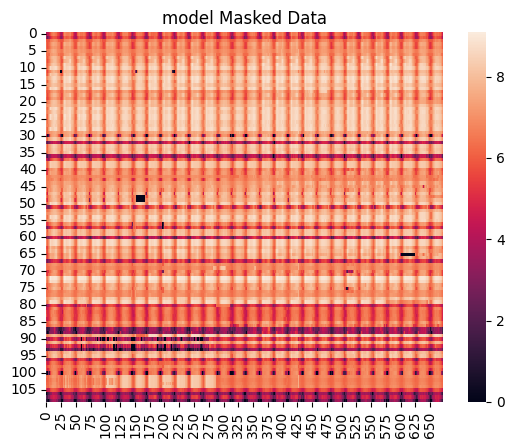

<Figure size 640x480 with 0 Axes>

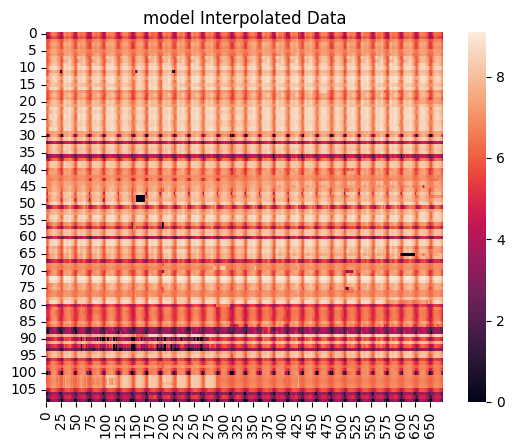

<Figure size 640x480 with 0 Axes>

norm_int_dat 109
norm_dat 109
Train 109
Test 109
Training Data Length:  109 X 504
Test Data Length:  109 X 168
Testing percentage:  25.0 %
Total data size:  109 X 672
period: 15
len(dat[0]): 504
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 1
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 2
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 3
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 4
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 5
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 6
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 7
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 8
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 9
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 10
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 11
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 12
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 13
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 14
x_temp shape: (109, 12)
y_temp shape: (109, 2)
i: 15
x_temp shape: (109,

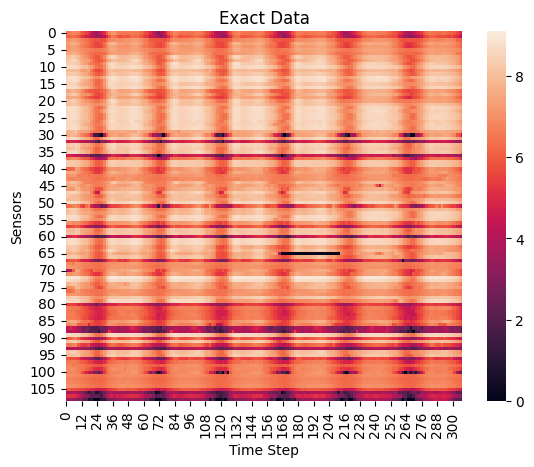

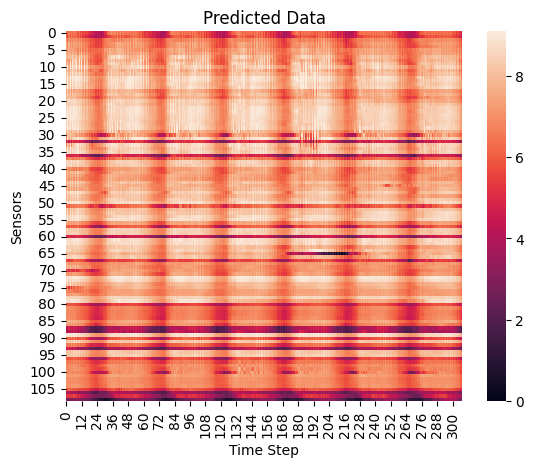

error shape:  (109, 308)


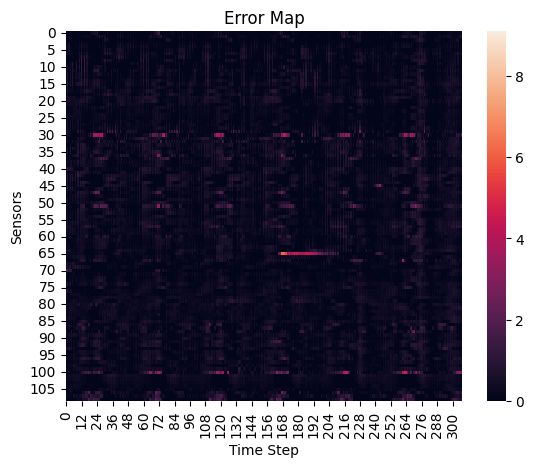

predict data size:  109 308
exact data size:  109 308
Predicted Data Point size for sensor 1  308
Predicted Data Point size for sensor 2  308
Predicted Data Point size for sensor 3  308
Predicted Data Point size for sensor 4  308
Predicted Data Point size for sensor 5  308
Predicted Data Point size for sensor 6  308
Predicted Data Point size for sensor 7  308
Predicted Data Point size for sensor 8  308
Predicted Data Point size for sensor 9  308
Predicted Data Point size for sensor 10  308
Predicted Data Point size for sensor 11  308
Predicted Data Point size for sensor 12  308
Predicted Data Point size for sensor 13  308
Predicted Data Point size for sensor 14  308
Predicted Data Point size for sensor 15  308
Predicted Data Point size for sensor 16  308
Predicted Data Point size for sensor 17  308
Predicted Data Point size for sensor 18  308
Predicted Data Point size for sensor 19  308
Predicted Data Point size for sensor 20  308
Predicted Data Point size for sensor 21  308
Predicted 

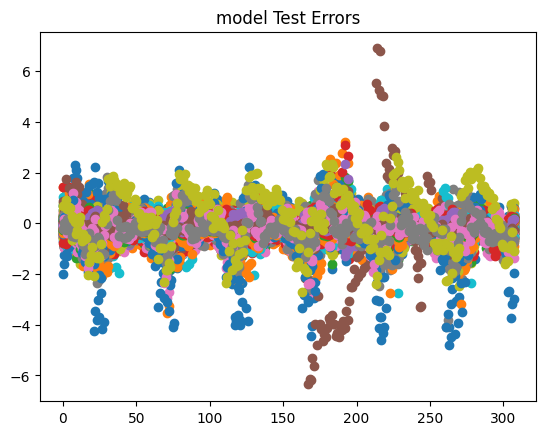

In [ ]:
test1_list = test1.values.tolist()
p1, p2 = .75, 1
train_hour =6
predict_hour = 1
predict_position = 1
adcp_py, adcp_ty, adcp_error,adcp_sd, adcp_model = SP_Learner(test1_list,train_hour*2 ,predict_hour*2,predict_position*2-1,1,p1,p2,'model')


In [ ]:
# Sensor MAEs and STDs:
for i in range(len(test1_list)):
    print('MAE for sensor'+str(i+1)+' ', adcp_error[i], ' STD: ', adcp_sd[i])
print('Total MAE', np.mean(adcp_error), 'Total STD: ', np.mean(adcp_sd))

MAE for sensor1  145.2581804556173  STD:  122.93443601715441
MAE for sensor2  84.85781545929119  STD:  74.64854297553755
MAE for sensor3  158.77710158505081  STD:  143.61671285457822
MAE for sensor4  289.08608111476775  STD:  240.6830360132496
MAE for sensor5  219.1014502003025  STD:  163.6563708474232
MAE for sensor6  214.70897754021166  STD:  179.20668330965205
MAE for sensor7  264.0748465549027  STD:  228.88241458843854
MAE for sensor8  586.2032482514988  STD:  559.1257028151065
MAE for sensor9  565.8534953408555  STD:  540.5961953719958
MAE for sensor10  725.0664294168951  STD:  705.6354485030814
MAE for sensor11  750.8217748320288  STD:  582.9838701625958
MAE for sensor12  424.4255795700415  STD:  352.4766925444931
MAE for sensor13  514.7882798739788  STD:  401.36639007894405
MAE for sensor14  803.2065972886945  STD:  689.4723624507349
MAE for sensor15  844.8295913839883  STD:  743.3126417927581
MAE for sensor16  635.8814632968232  STD:  575.5608680757132
MAE for sensor17  745.793

Save all the predicted graphs for all detectors

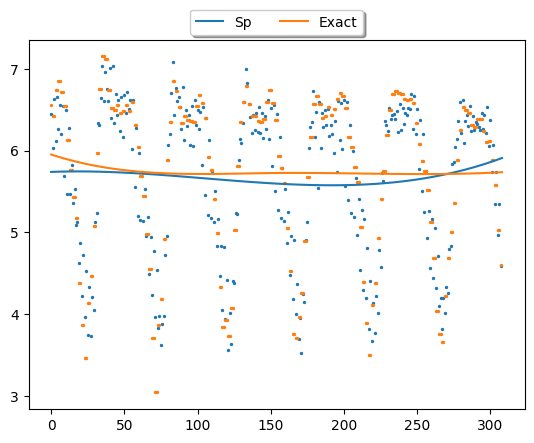

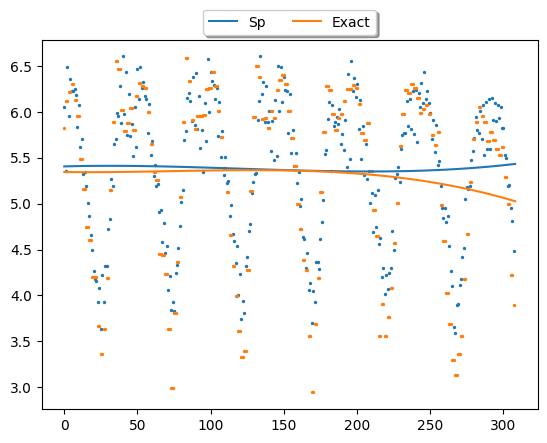

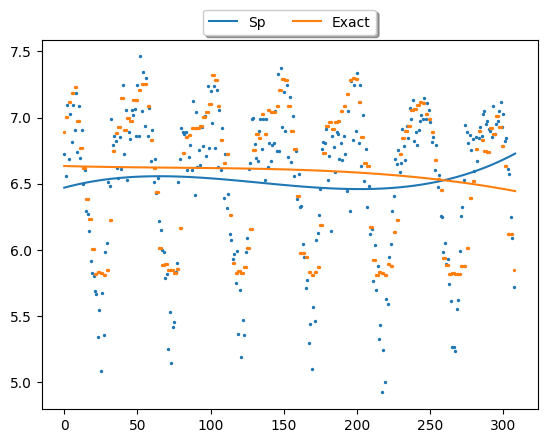

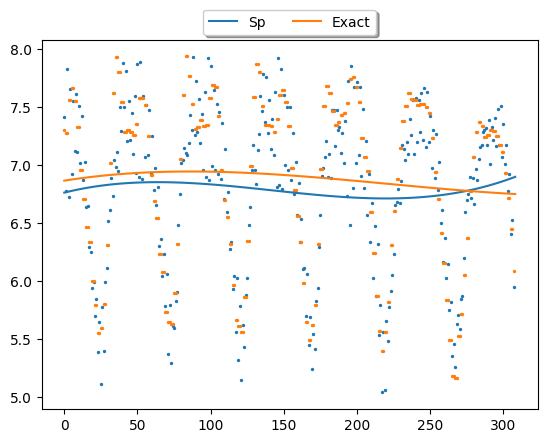

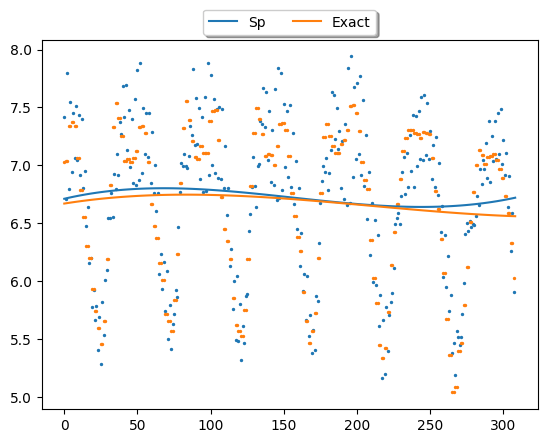

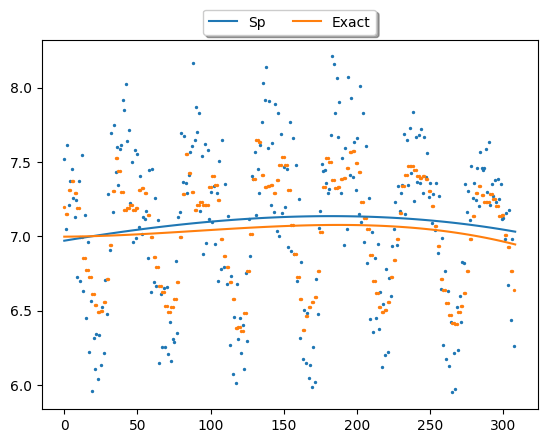

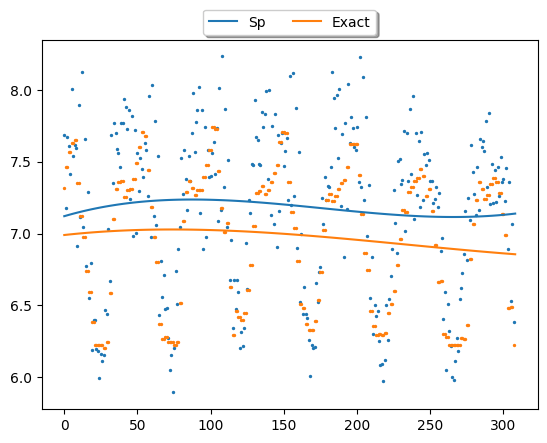

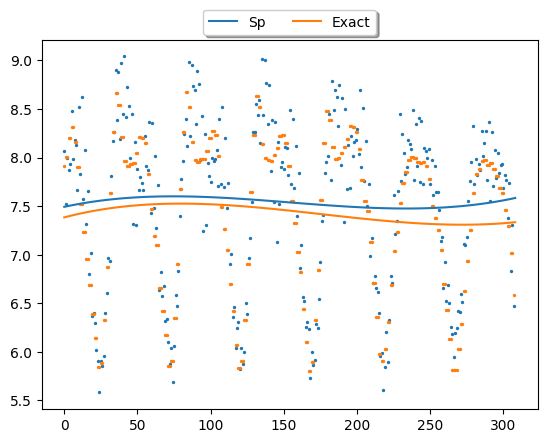

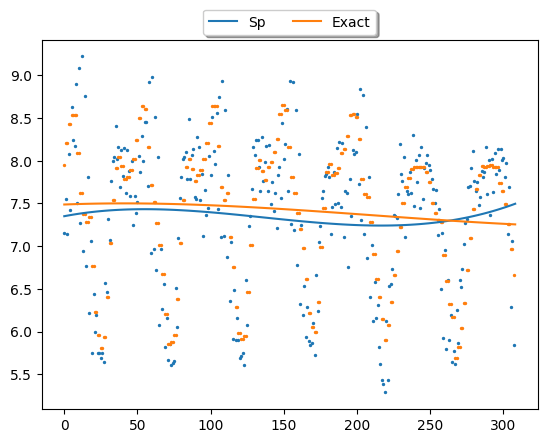

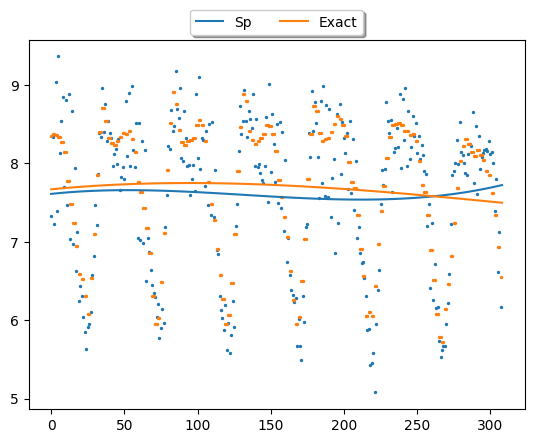

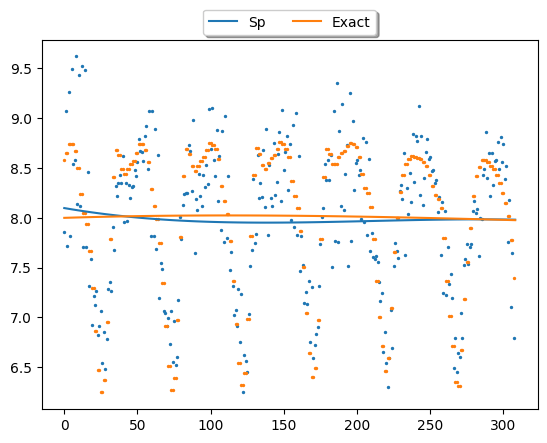

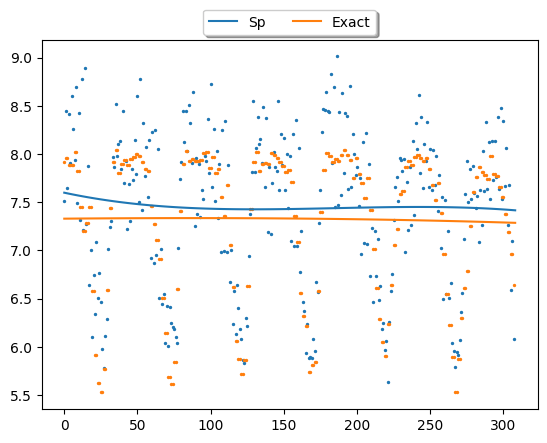

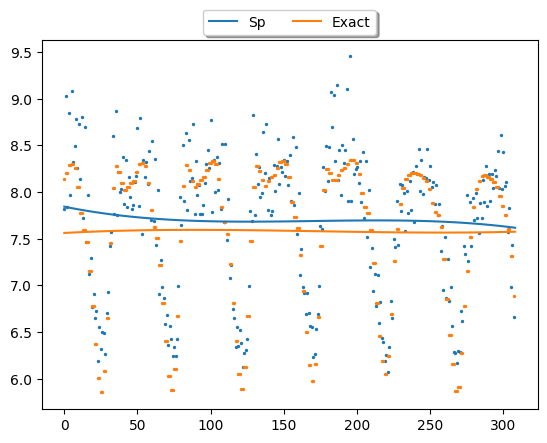

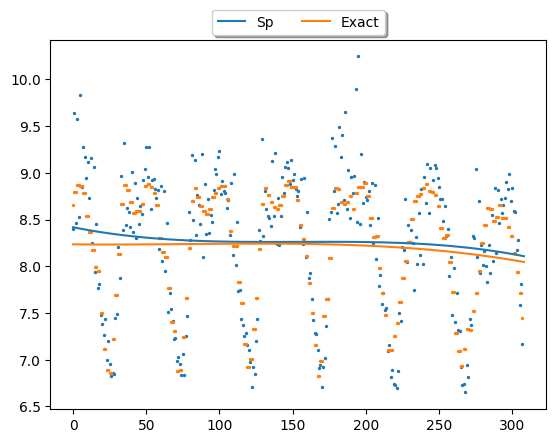

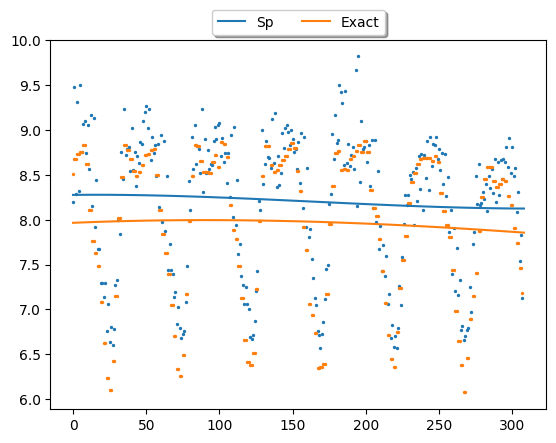

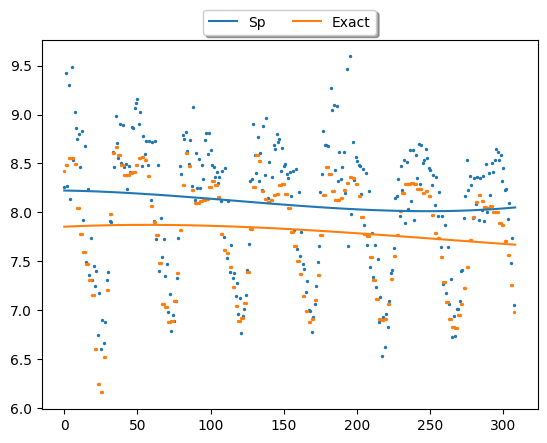

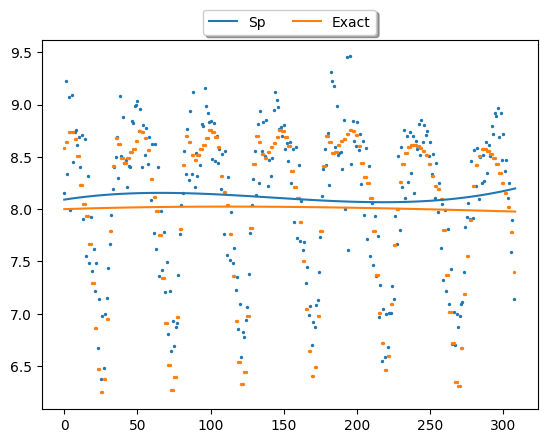

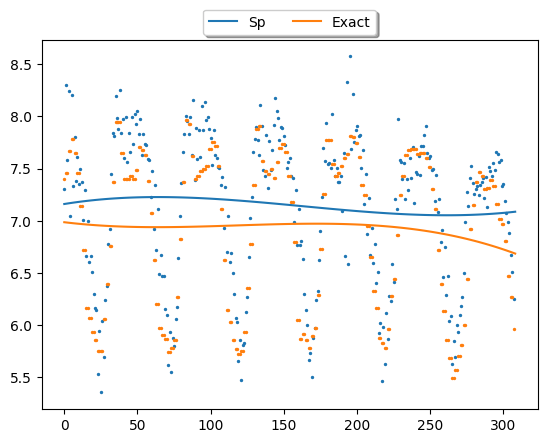

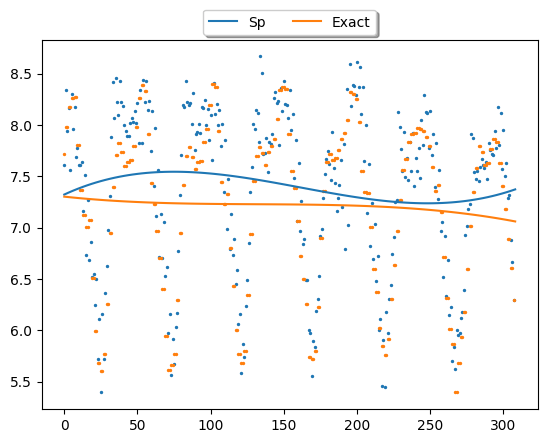

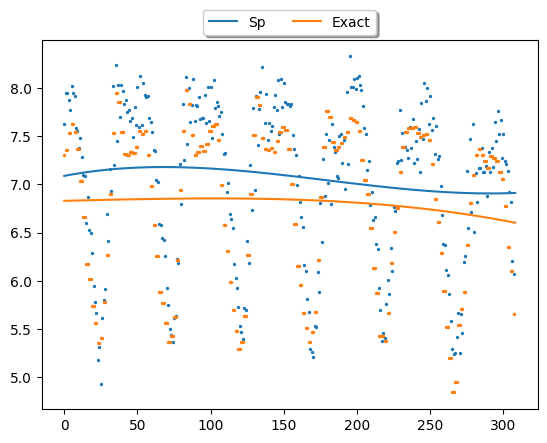

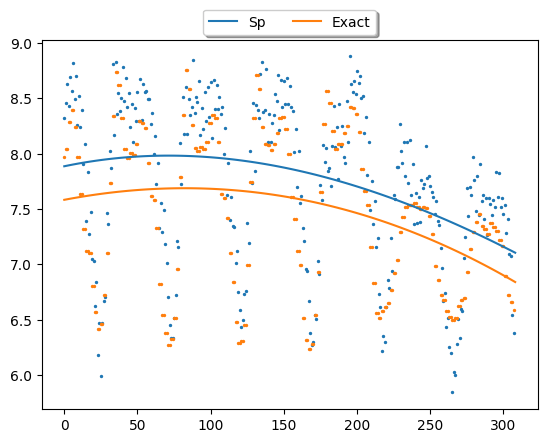

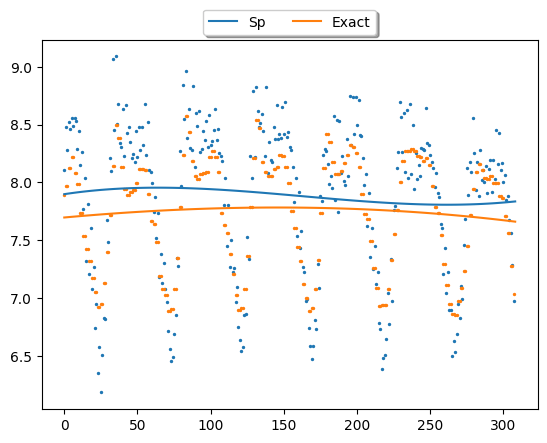

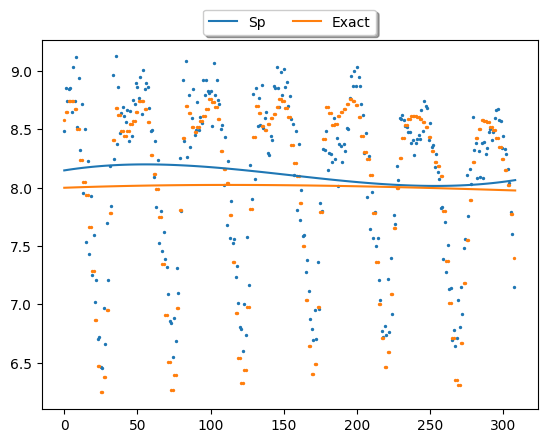

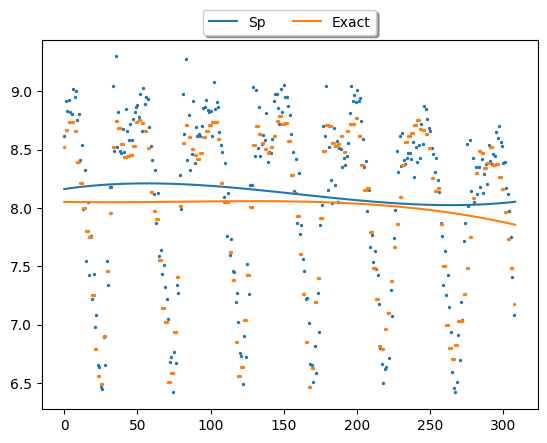

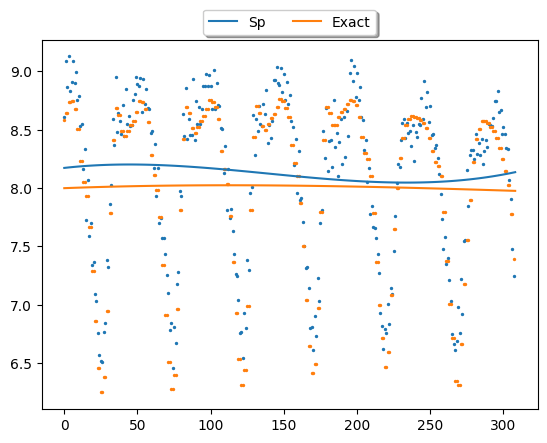

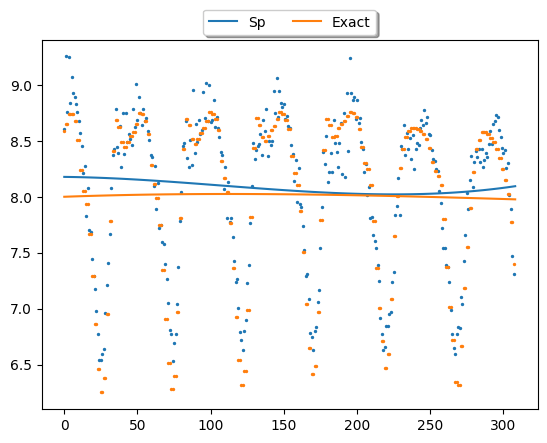

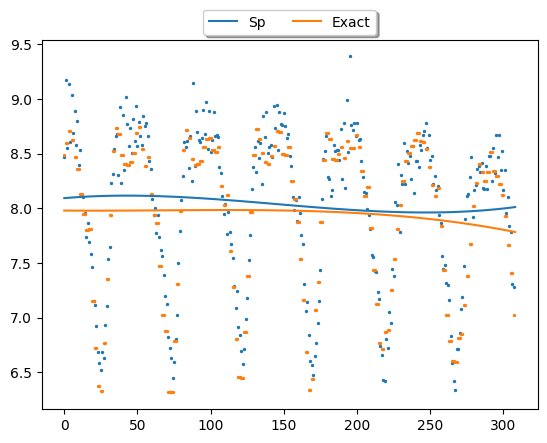

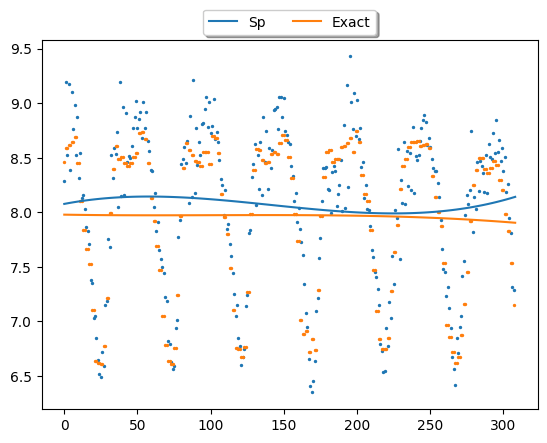

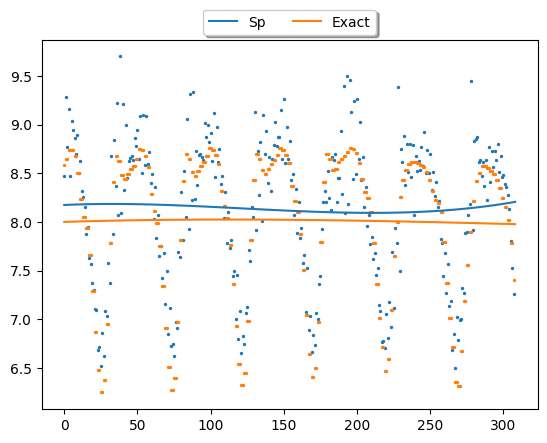

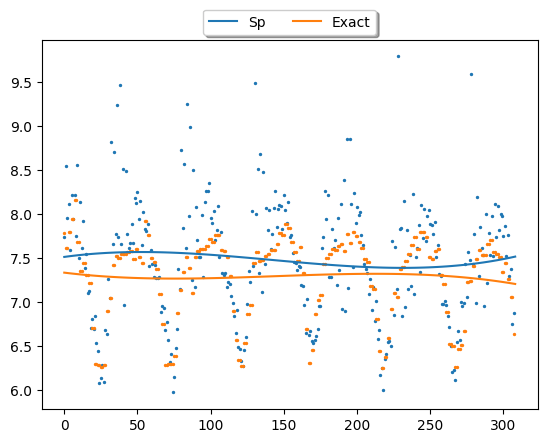

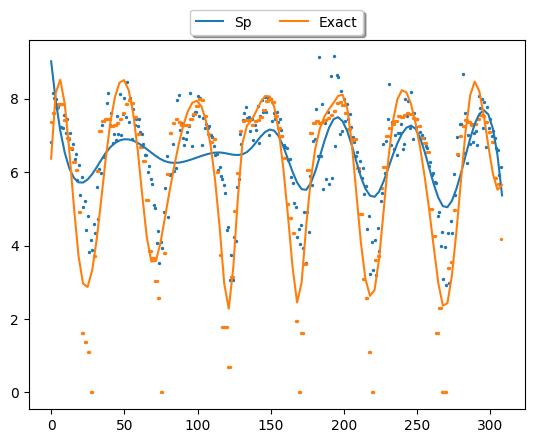

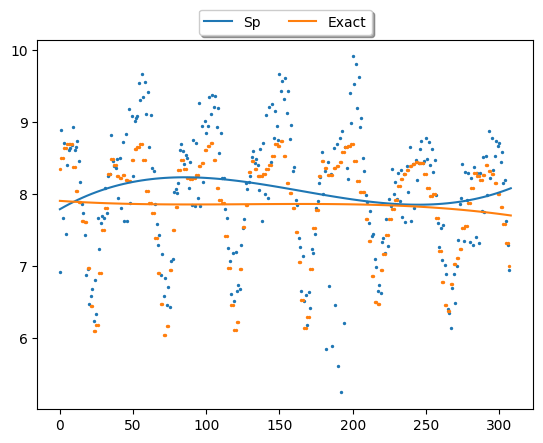

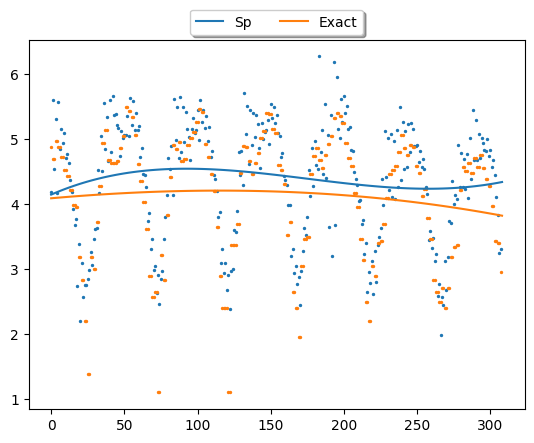

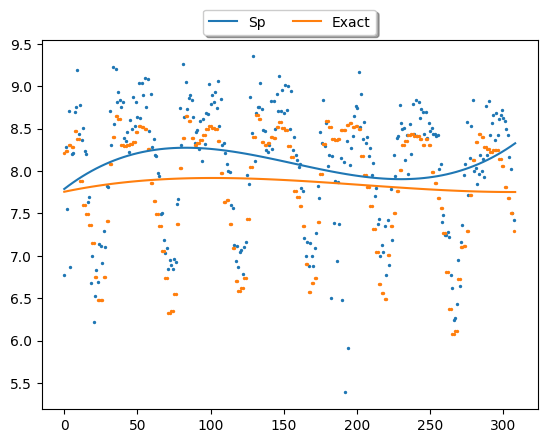

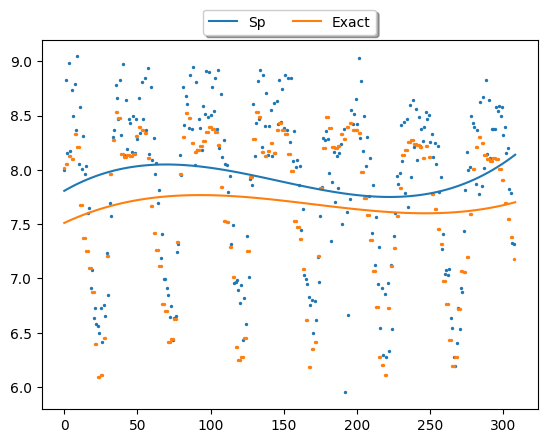

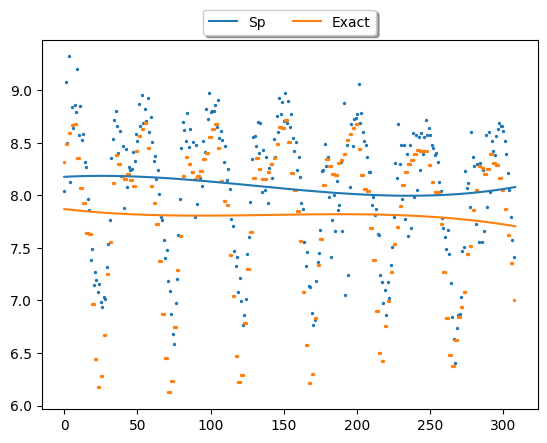

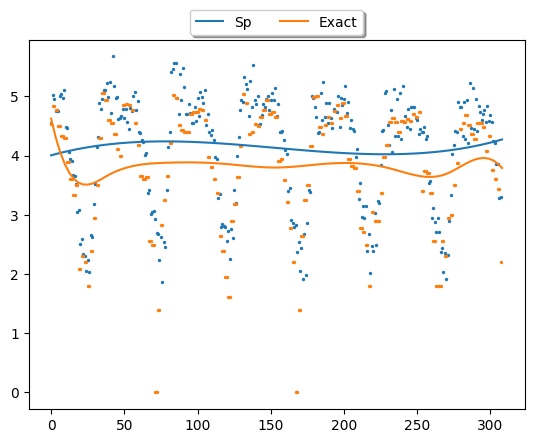

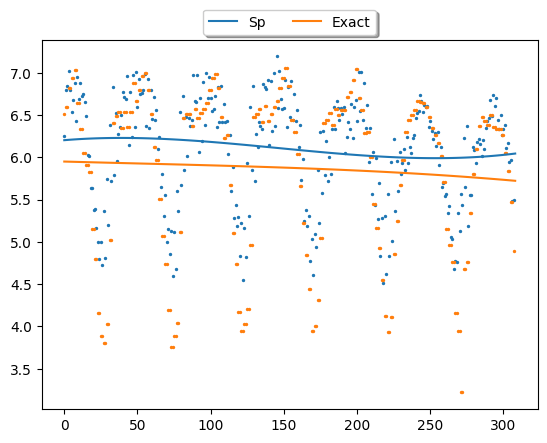

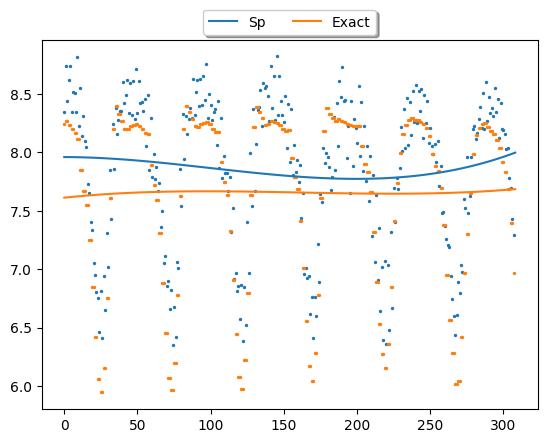

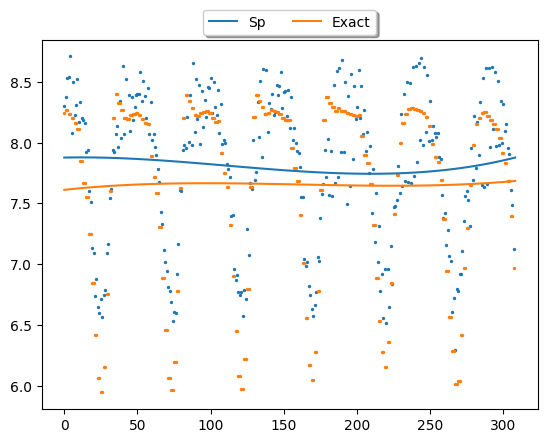

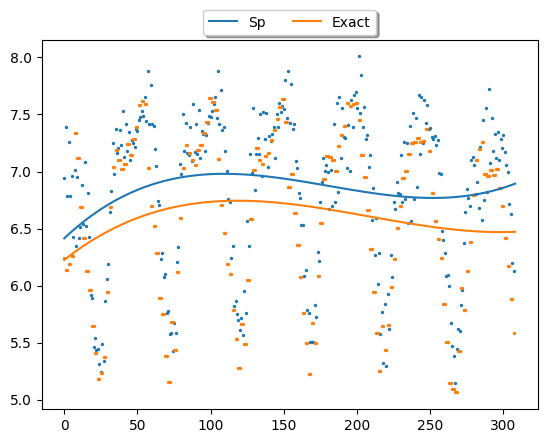

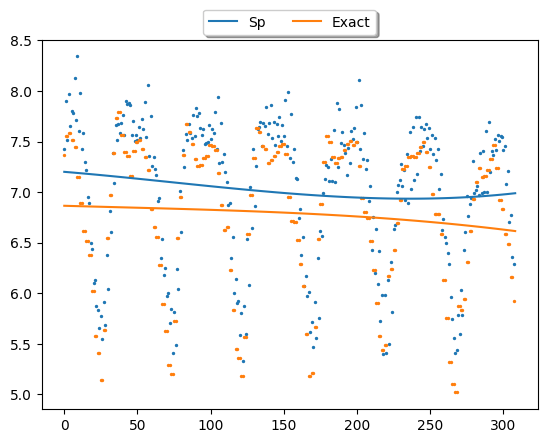

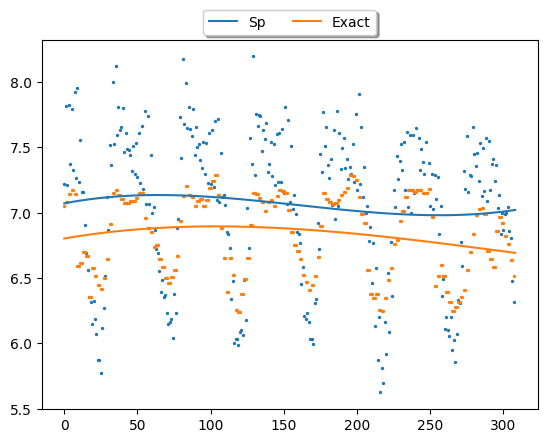

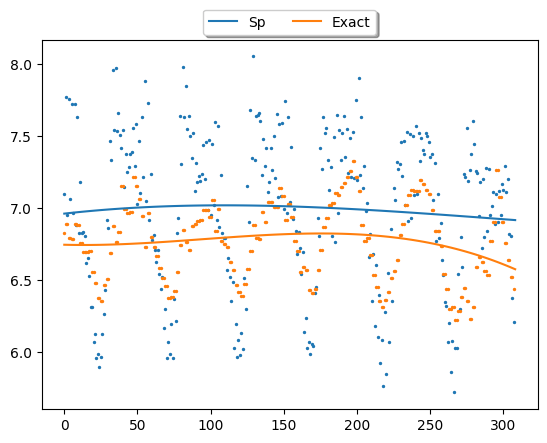

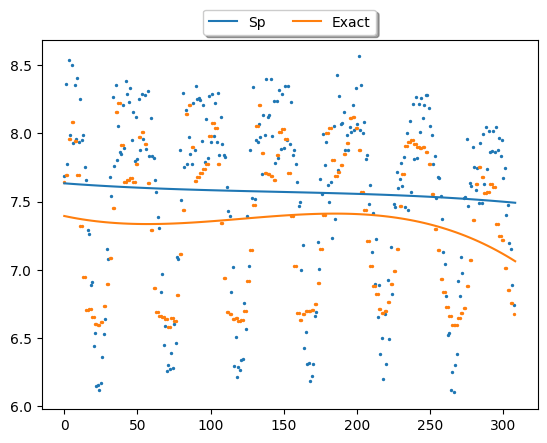

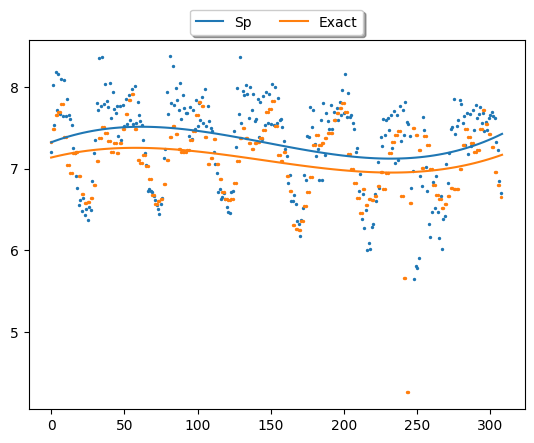

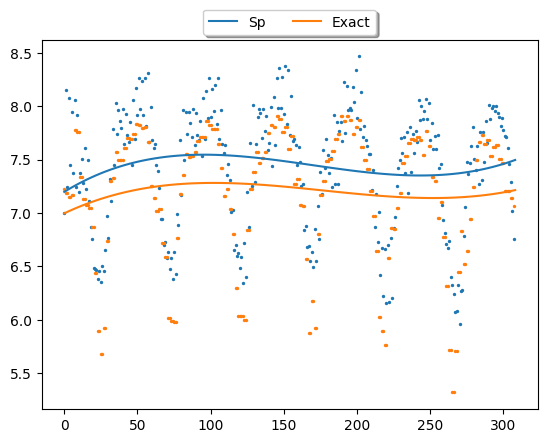

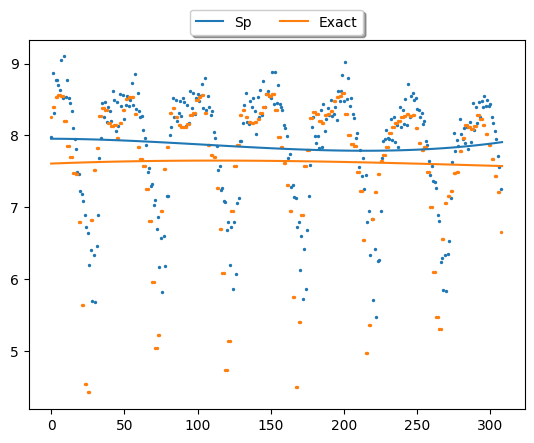

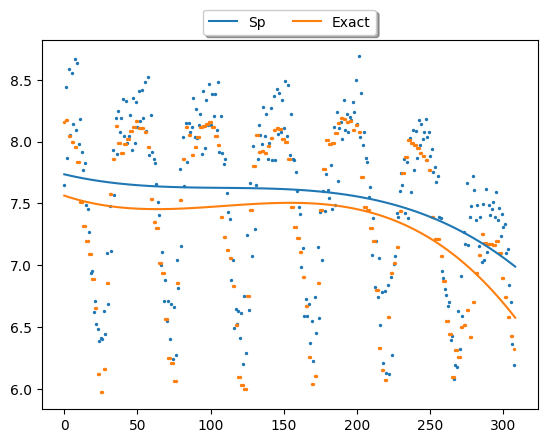

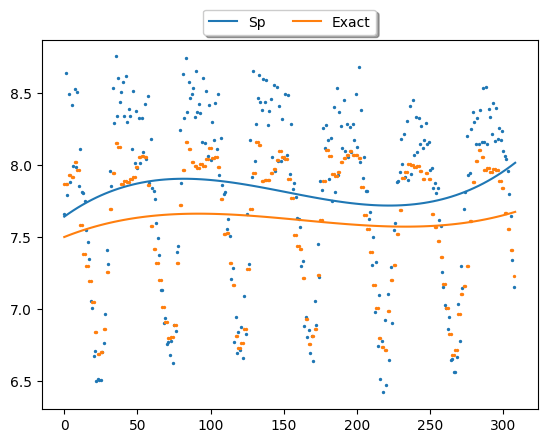

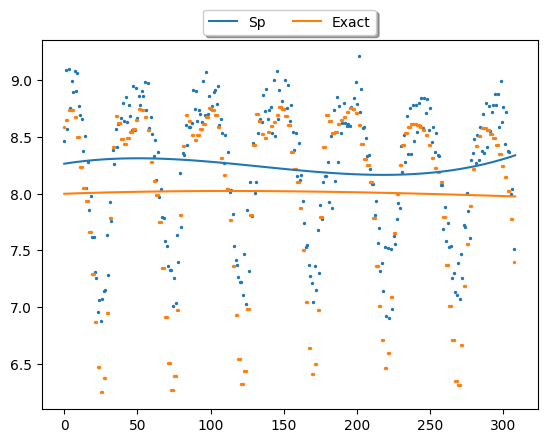

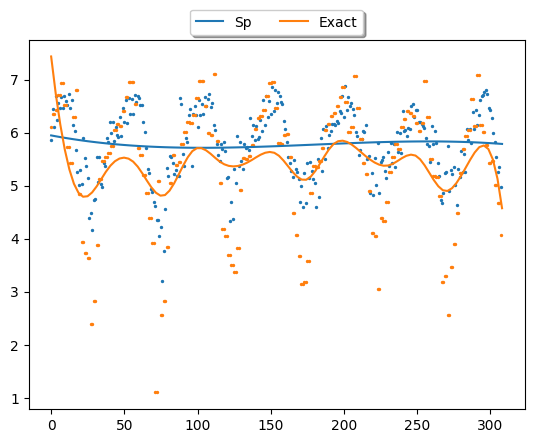

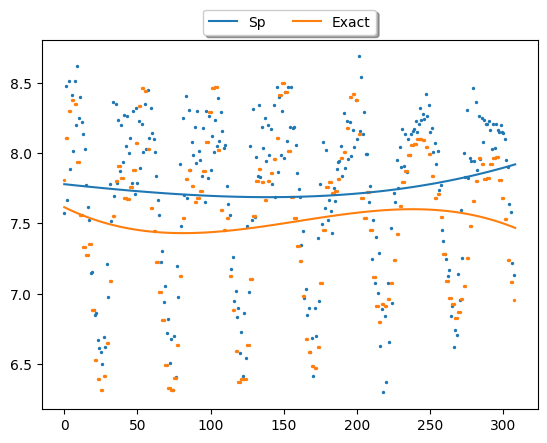

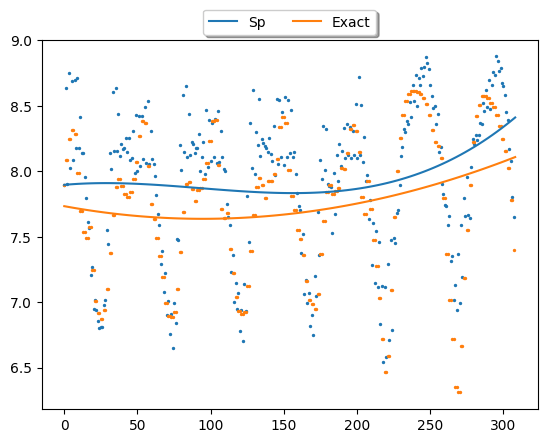

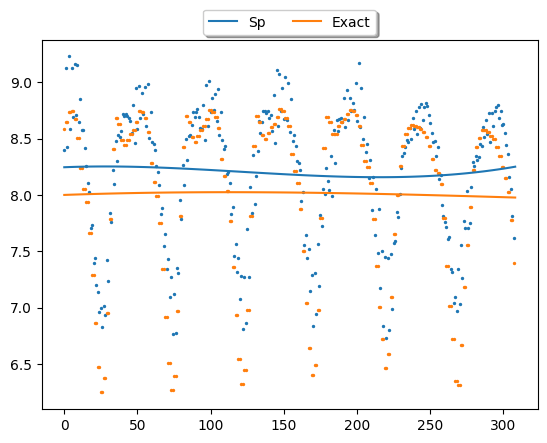

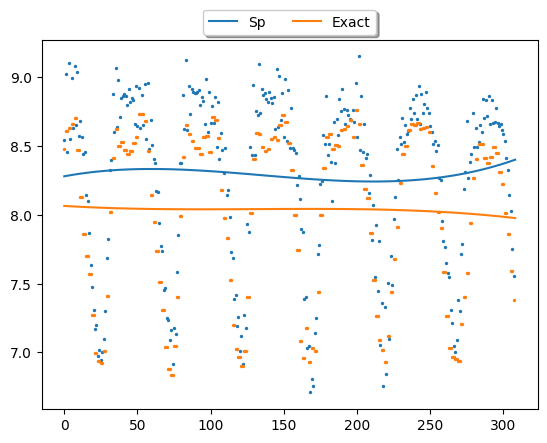

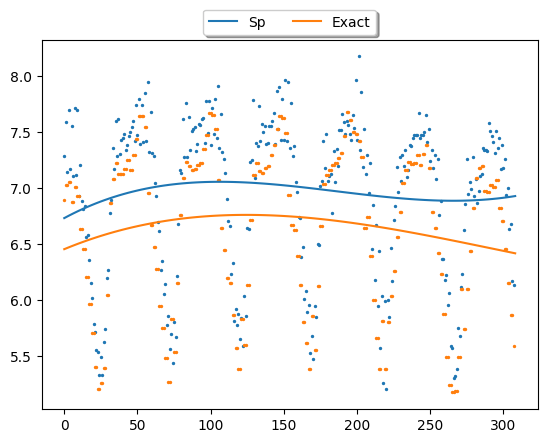

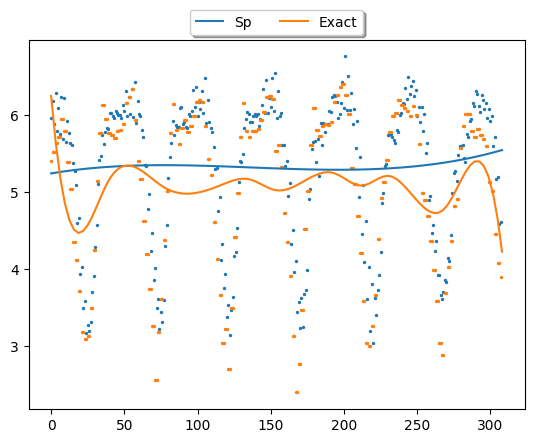

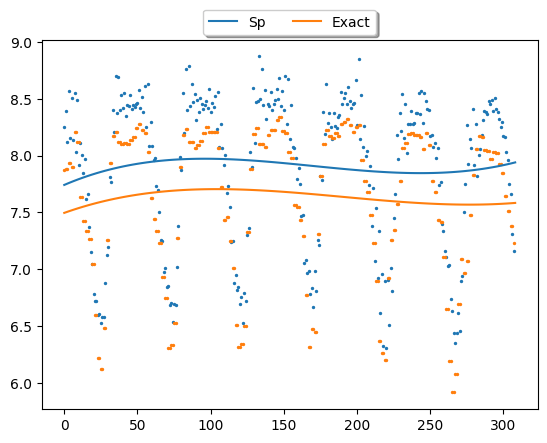

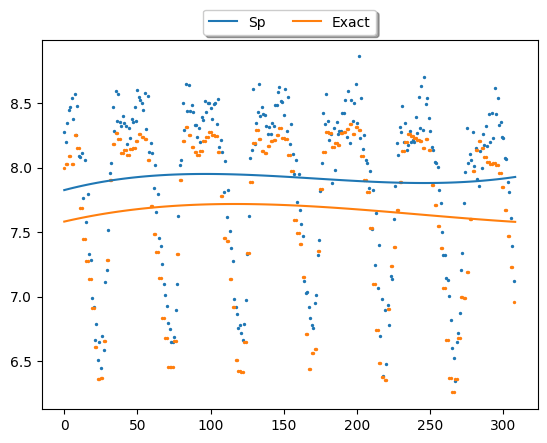

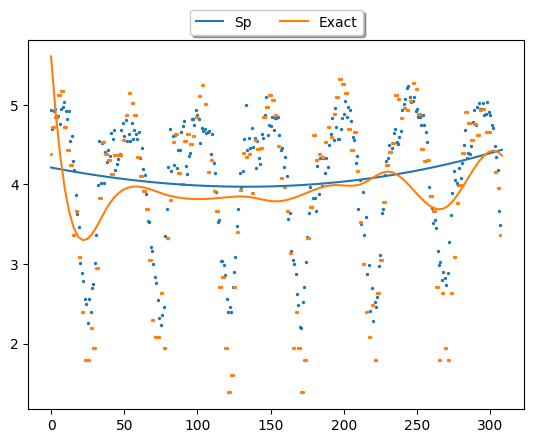

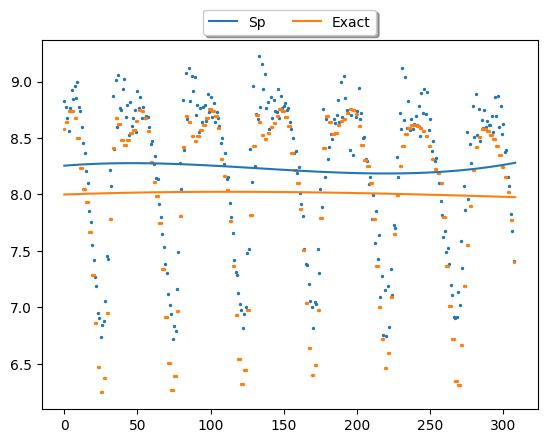

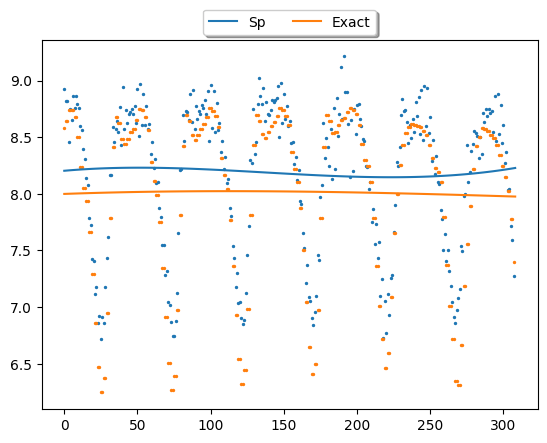

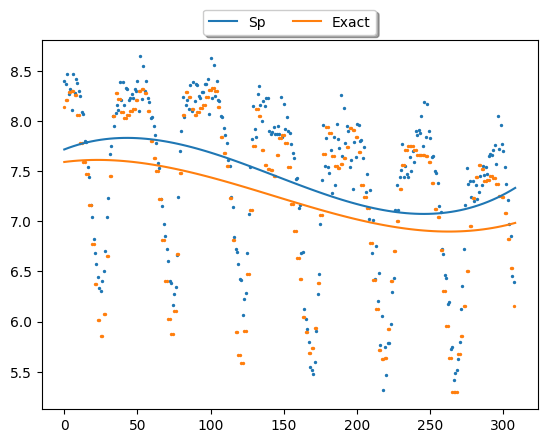

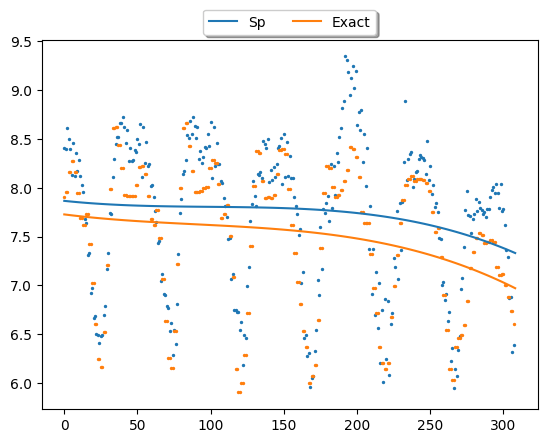

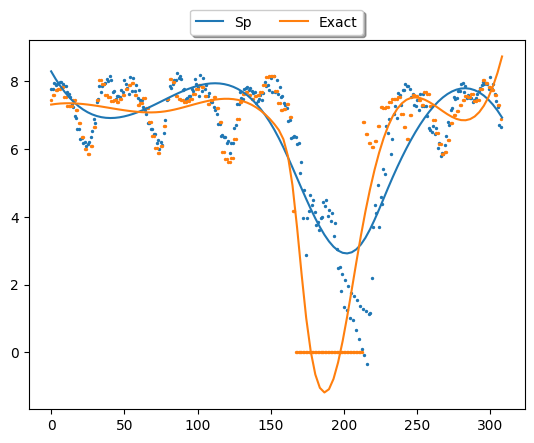

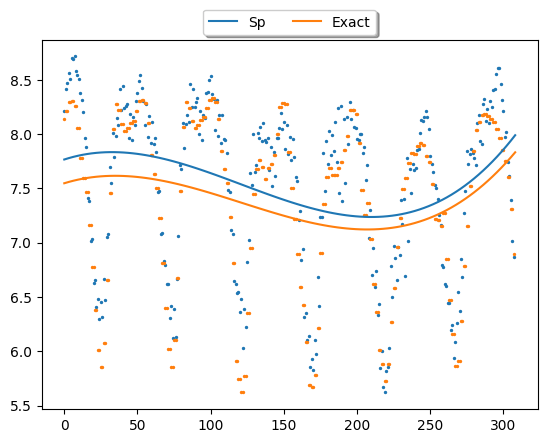

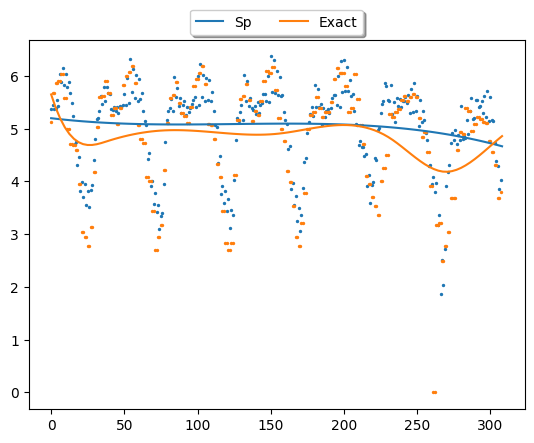

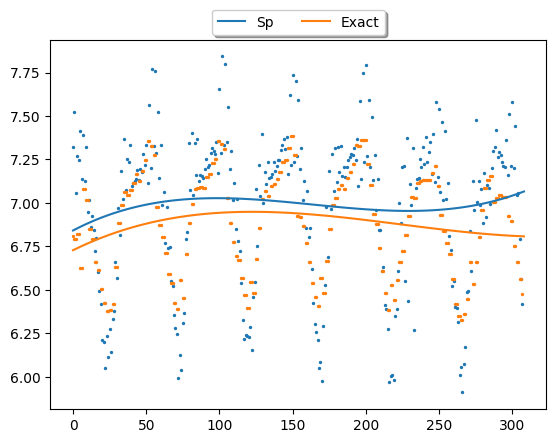

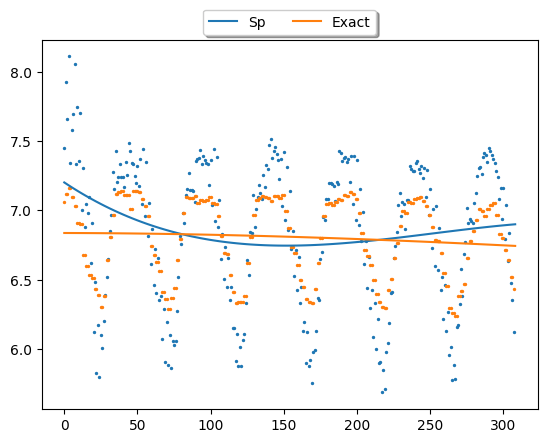

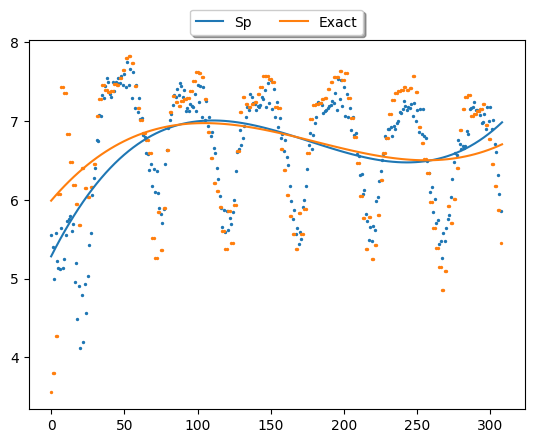

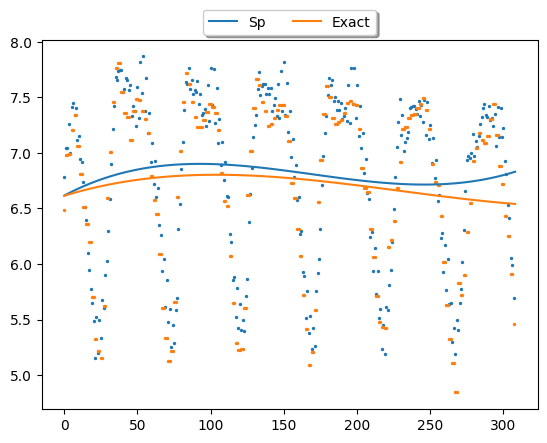

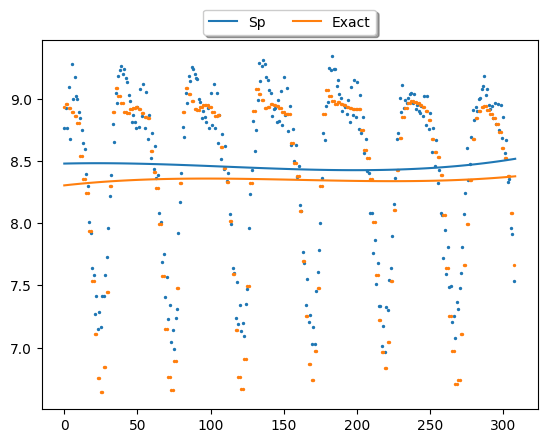

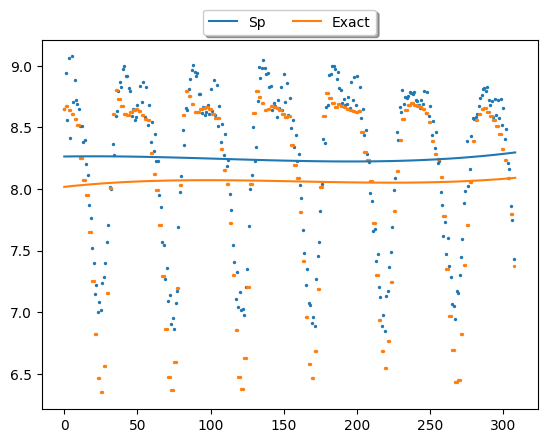

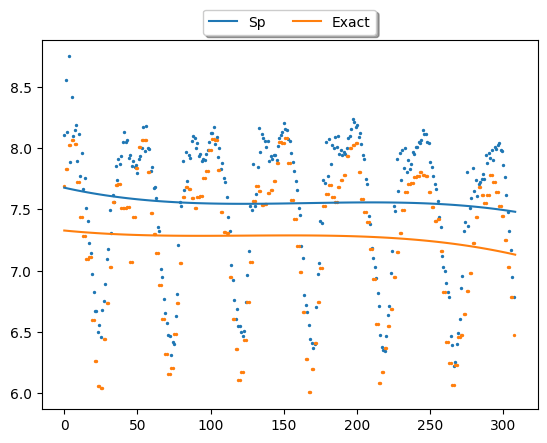

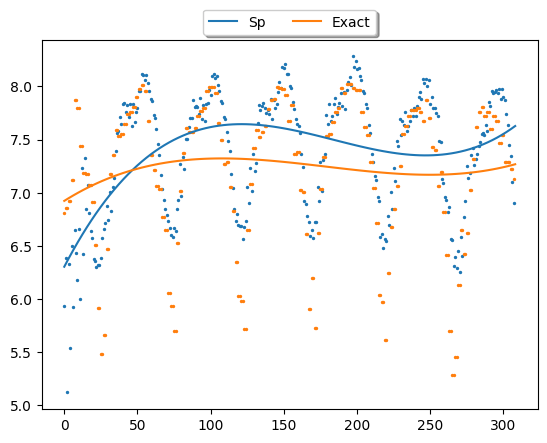

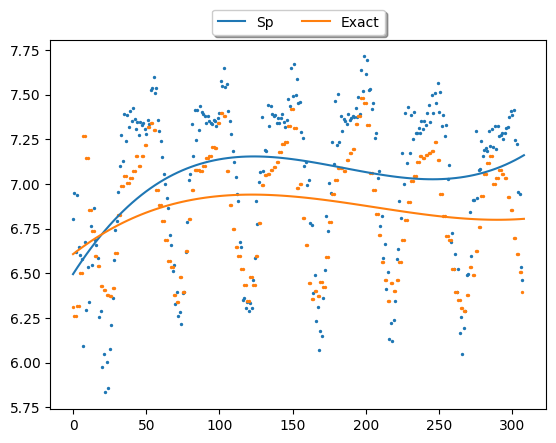

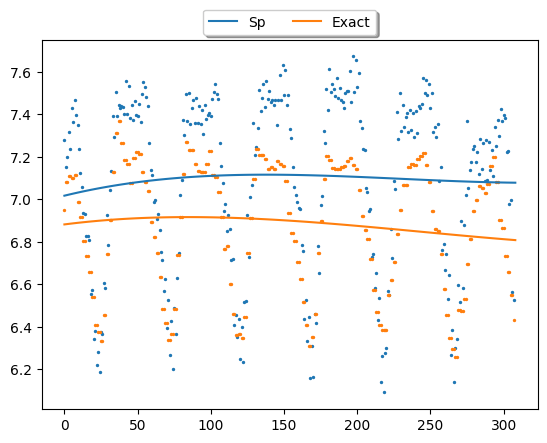

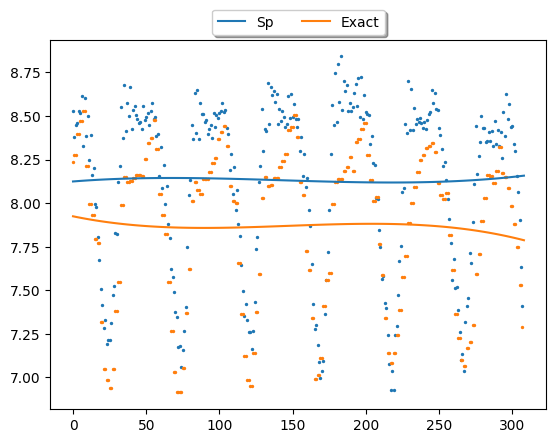

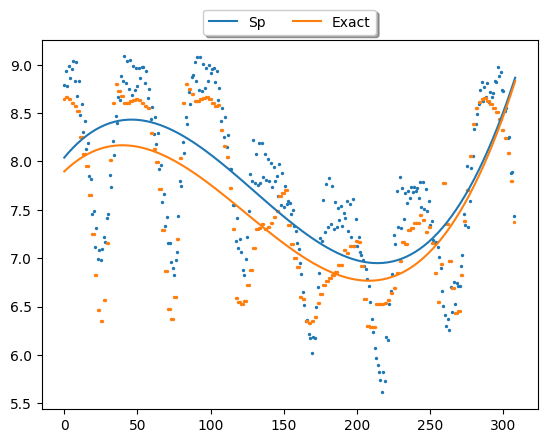

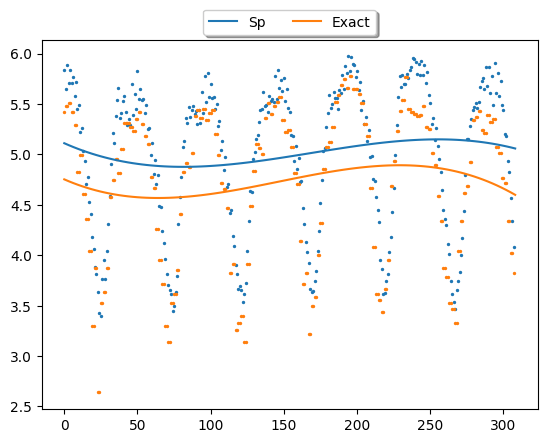

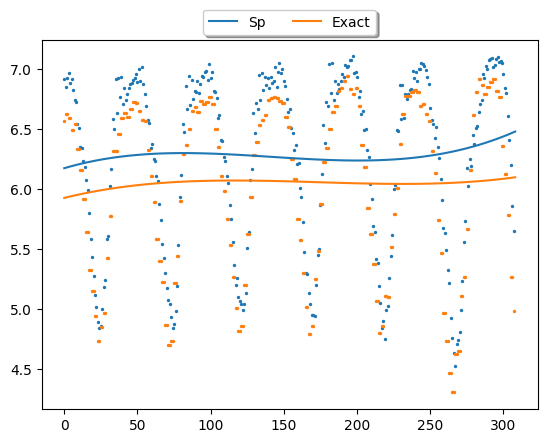

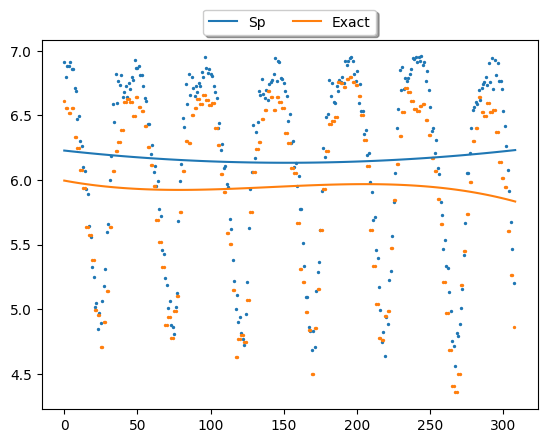

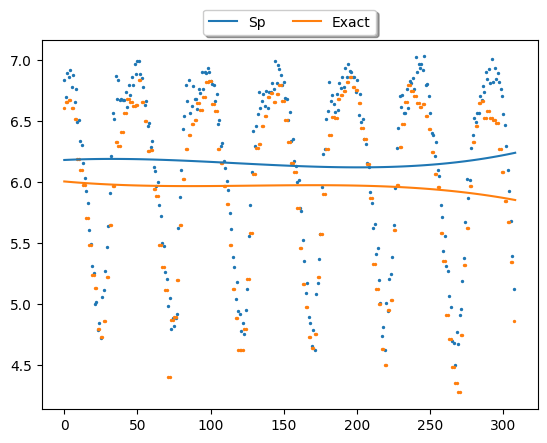

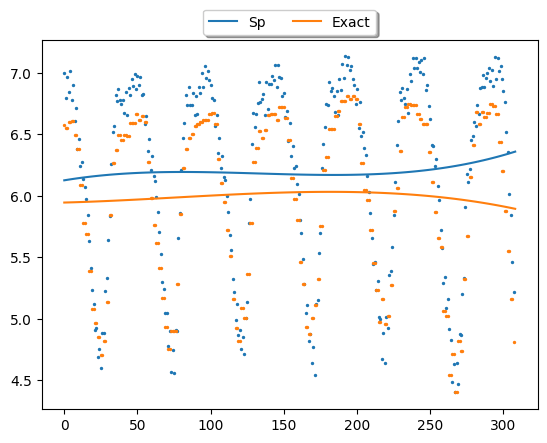

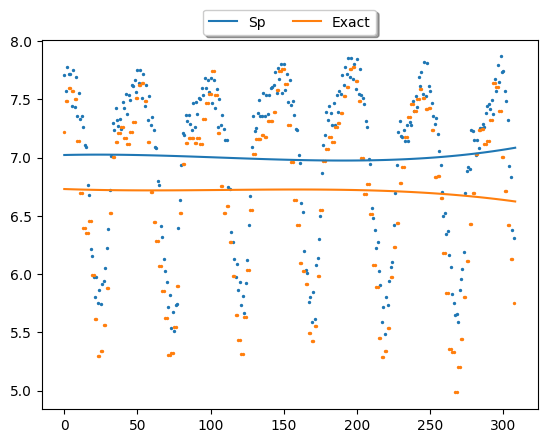

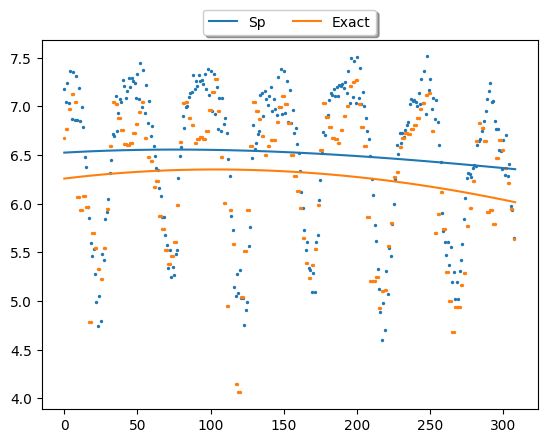

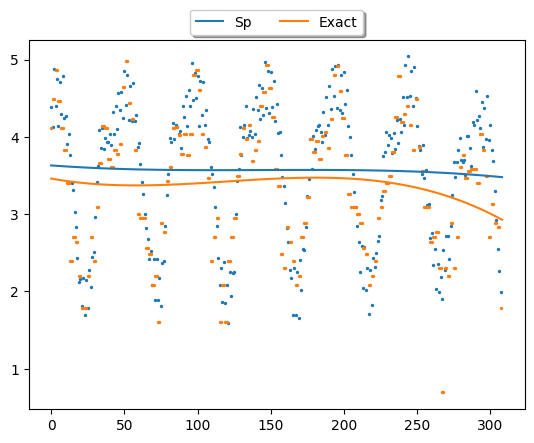

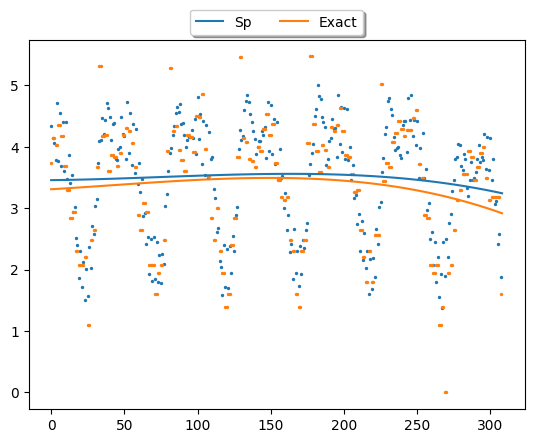

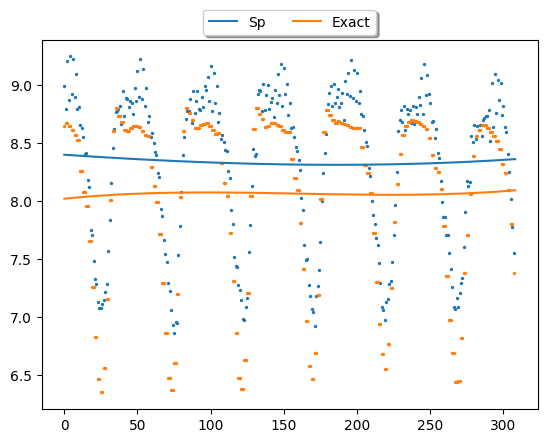

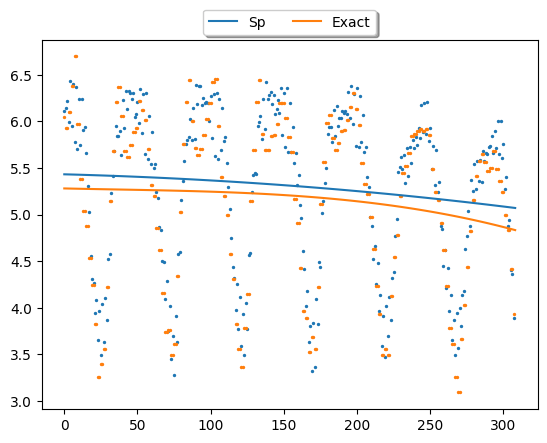

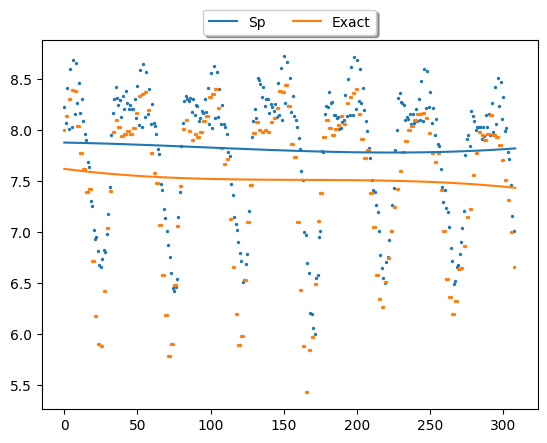

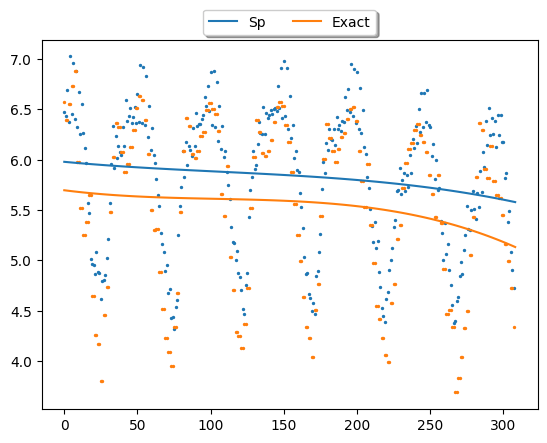

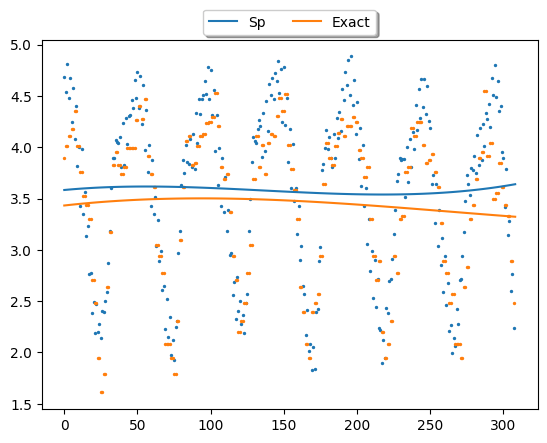

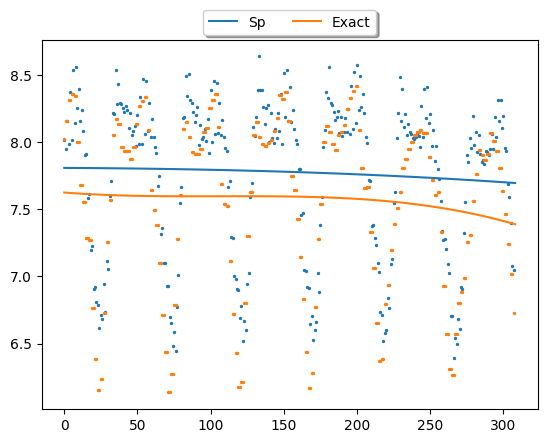

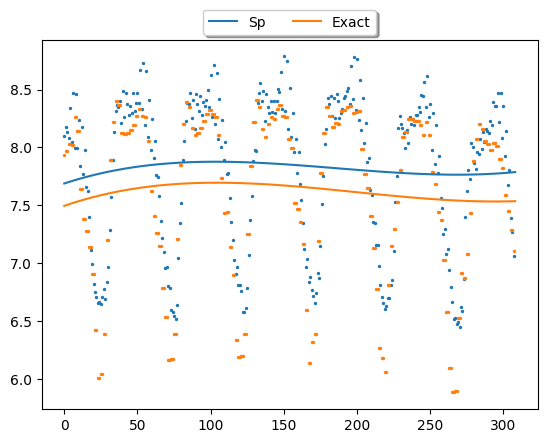

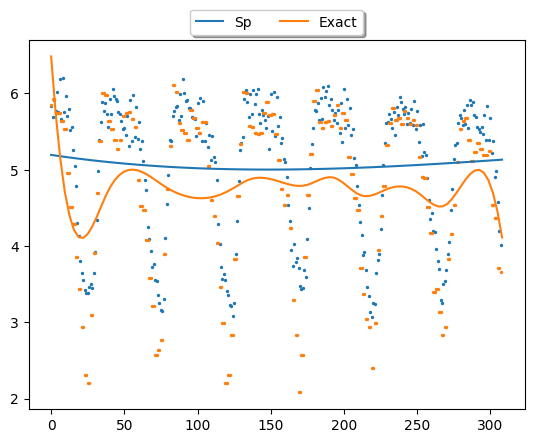

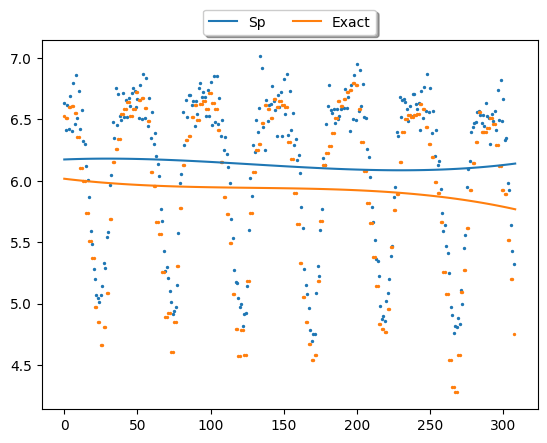

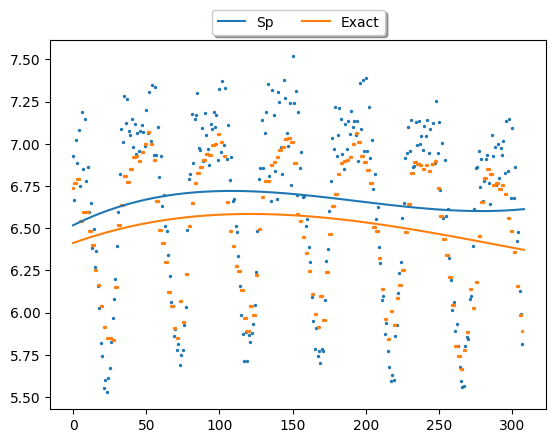

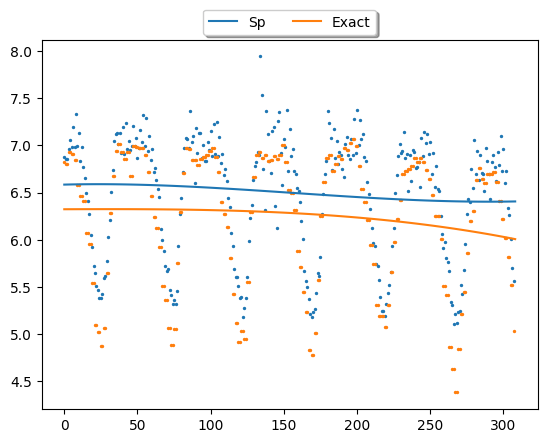

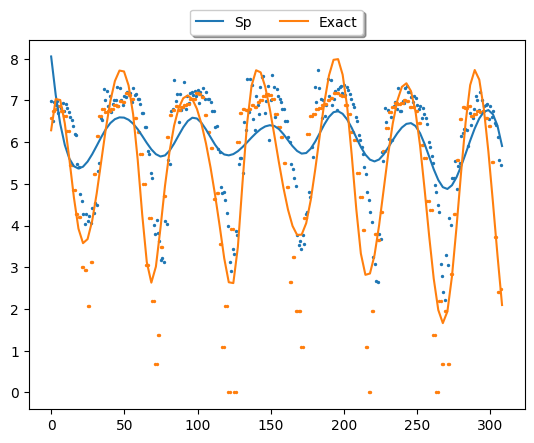

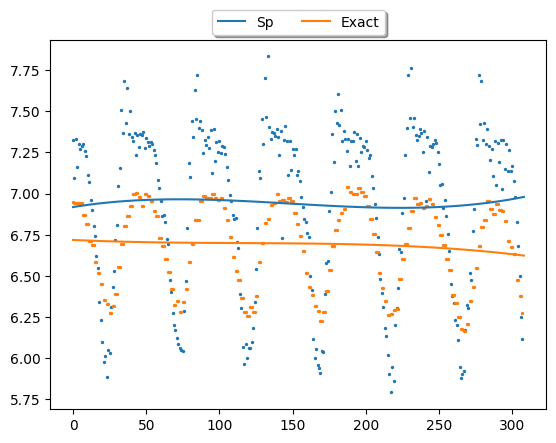

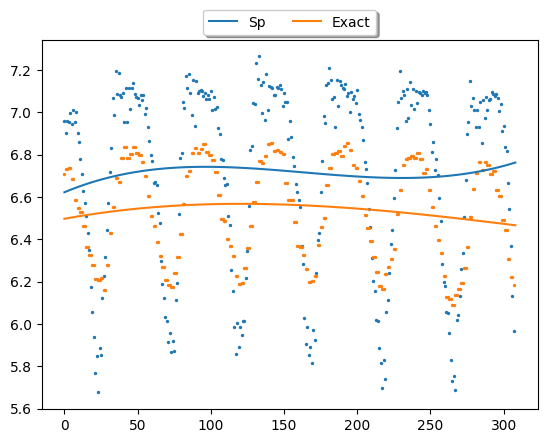

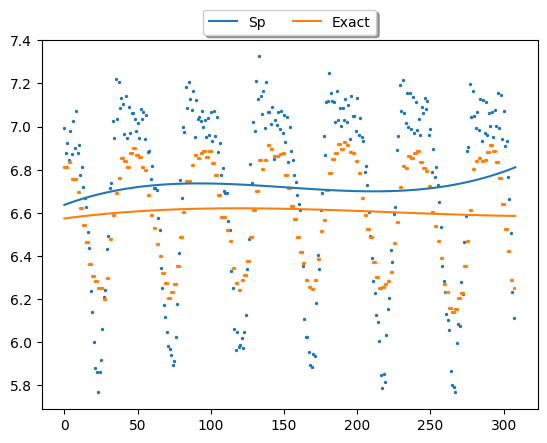

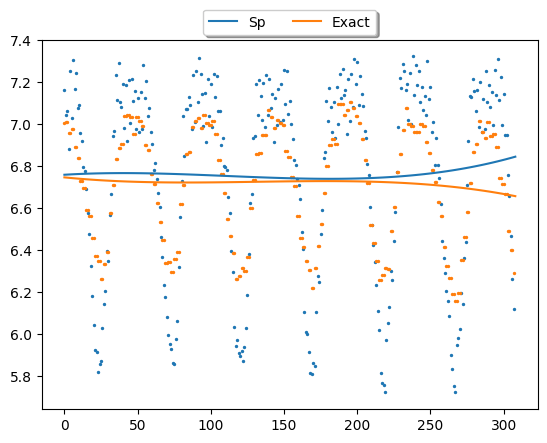

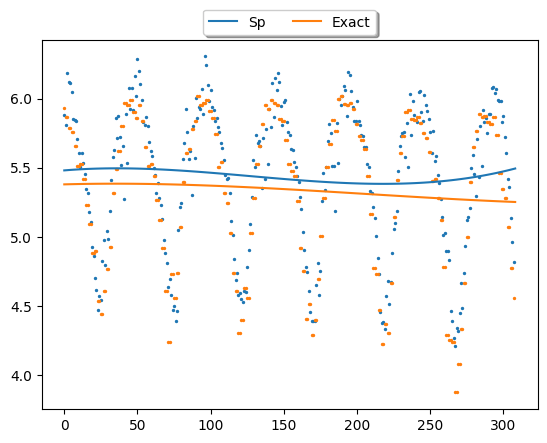

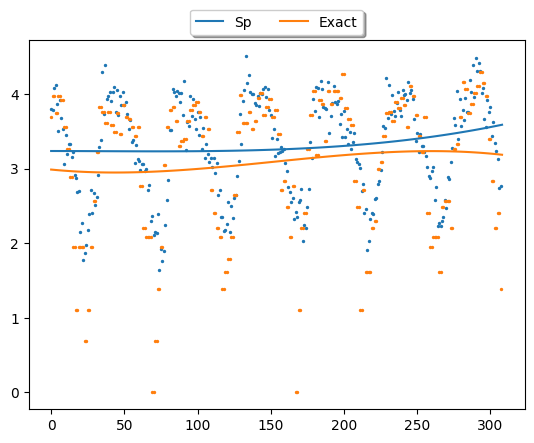

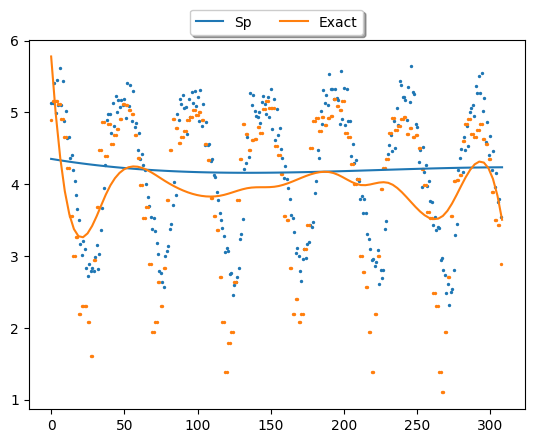

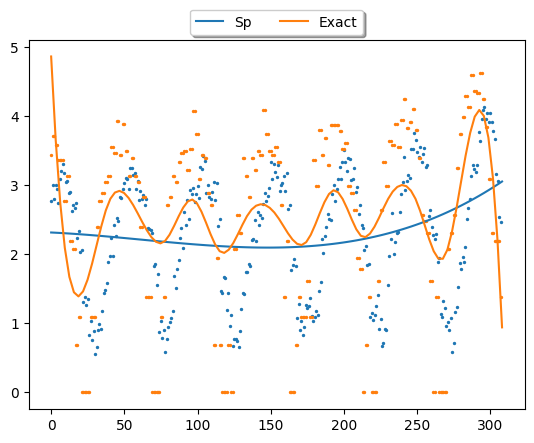

In [ ]:
for i in range(len(test1_list)):
    py_ty_plot(adcp_py, adcp_ty,2,100, 'ADCP_sensor_plot',i)